In [18]:
# this can be used to compare uniform and covering strategies, as well as increase in population size for delta=3
# reference fitness is in `ga_early.ipynb` notebook (0.865) and `ga_cover_d3.ipynb` (0.845)
%load_ext cython
import numpy as np
import pandas as pd
from viz import show_field

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [19]:
%%cython
M = ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1))
NROW = NCOL = 20
import numpy as np
cdef int calc_neighs(field, i, j):
    cdef int neighs, n, row_idx, col_idx
    neighs = 0
    n = len(field)
    for m in M:
        row_idx = m[0] + i
        col_idx = m[1] + j
        if 0 <= row_idx < n and 0 <= col_idx < n:
            if field[row_idx][col_idx]:
                neighs += 1
    return neighs

cdef make_move(field, moves=1):
    cdef int n, i, j, neighs
    n = len(field)
    cur_field = field
    for _ in range(moves):
        new_field = np.zeros((n, n), dtype='uint8')
        for i in range(n):
            for j in range(n):
                neighs = calc_neighs(cur_field, i, j)
                if cur_field[i][j] and neighs == 2:
                    new_field[i][j] = 1
                if neighs == 3:
                    new_field[i][j] = 1
        cur_field = new_field
    return cur_field


In [20]:
import numpy as np

M = ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1))
NROW = NCOL = 20

def generate_field(delta, flat=False):
    field = np.random.randint(0, 2, size=(20, 20), dtype='uint8')
    field = make_move(field, moves=delta)
    return field

def generate_data_row(delta):
    start_field = generate_field(delta)
    end_field = make_move(start_field, delta)
    return np.hstack((np.array(delta).reshape(1, -1), start_field.reshape(1, -1), end_field.reshape(1, -1))).ravel()

def generate_sample(delta=1, skip_first=5, ravel=True):
    """
    Generate training sample

    @return: (end_frame, start_frame)
    """
    start_frame = generate_field(skip_first)
    end_frame = make_move(start_frame, delta)
    return (end_frame, start_frame) if not ravel else (end_frame.ravel(), start_frame.ravel())

def generate_samples(delta=1, n=32):
    """
    Generate batch of samples

    @return: (end_frames, start_frames)
    """
    X = np.zeros((n, NROW * NCOL))
    Y = np.zeros((n, NROW * NCOL))
    for i in range(n):
        x, y = generate_sample(delta)
        X[i, :] = x
        Y[i, :] = y
    return X, Y

def data_generator(delta=1, batch_size=32):
    """
    Can be used along with .fit_generator to generate training samples on the fly
    """
    while True:
        yield generate_samples(delta=delta, n=batch_size)

def train_row_to_windowed_data(row):
    delta, start_field, end_field = row[0], row[1:401].reshape(20, 20), row[401:].reshape(20, 20)
    padded = np.pad(end_field, delta, mode="constant", constant_values=-1)
    rows = []
    labels = []
    n = len(start_field)
    for i in range(n):
        for j in range(n):
            window = padded[i:i+2*delta+1, j:j+2*delta+1]
            cell_status = start_field[i][j]
            rows.append(window.ravel())
            labels.append(cell_status)
    return (np.array(rows), np.array(labels).reshape(-1, 1))

def extract_features_from_raw_data(raw_data):
    X, y = [], []
    for row_idx in range(raw_data.shape[0]):
        field_X, field_y = train_row_to_windowed_data(raw_data[row_idx, :])
        X.append(field_X)
        y.append(field_y)
    return np.vstack(X), np.vstack(y)

def field_to_window_rows(end_field, delta):
    padded = np.pad(end_field, delta, mode="constant", constant_values=-1)
    rows = []

    n = len(end_field)
    for i in range(n):
        for j in range(n):
            window = padded[i:i+2*delta+1, j:j+2*delta+1]
            rows.append(window.ravel())
    return np.array(rows)

def predict_field(end_field, delta, model):


    rows = field_to_window_rows(end_field, delta)

    field = model.predict(rows)
    return field

def train_sample_windowize(field, delta=1, n=20):
    """ Same as the above, but with custom delta """
    padded = np.pad(field, delta, mode='constant', constant_values=-1)
    X = np.zeros((n * n, (1 + delta * 2) ** 2))
    for i in range(n):
        for j in range(n):
            X[i * n + j] = padded[i:i + 2 * delta + 1, j:j + 2 * delta + 1].ravel()
    return X

def window_data_proc(X, y=None, delta=1):
    """ Reformat data in window form and prepare for training """
    vectorize_windowing = lambda row: train_sample_windowize(row.reshape(20, 20), delta=delta)

    X = np.vstack(np.apply_along_axis(vectorize_windowing, 1, X))
    if y is not None:
        y = np.vstack(y.ravel())
        return X, y
    return X

# res = []
# for row_idx in range(test_df.values.shape[0]):
#     if row_idx % 1000 == 0:
#         print(row_idx)
#     row = test_df.values[row_idx, :]
#     delta = row[0]
#     field = row[1:].reshape(20, 20)
#     pred = predict_field(field, delta, models_by_delta[delta])
#     res.append(pred)


In [21]:
import numpy as np
import multiprocessing as mp


class GeneticSolver:
    def __init__(self, population_size=200, n_generations=300, retain_best=0.8, retain_random=0.05, mutate_chance=0.05,
                 verbosity=0, random_state=-1, warm_start=False, early_stopping=True, patience=20,
                 initialization_strategy='uniform'):
        """

        :param population_size: number of individual candidate solutions
        :param n_generations: number of generations
        :param retain_best: percentage of best candidates to select into the next generation
        :param retain_random: probability of selecting sub-optimal candidate into the next generation
        :param mutate_chance: candidate mutation chance
        :param verbosity: level of verbosity (0 - quiet, 1 - evolution information, 2 - spamming like in 2003)
        :param random_state: if specified, initializes seed with this value
        :param warm_start: if True, initial population generation step is omitted, allowing for continuing training
        :param early_stopping: if True, evolution will stop if top-10 candidates are not changing for several generations
        :param patience: number of generations to wait for best solution change when <early_stopping>
        :param initialization_strategy: initial population generation rule: 'uniform' or 'covering'
        """
        self.population_size = population_size
        self.n_generations = n_generations
        self.retain_best = retain_best
        self.retain_random = retain_random
        self.mutate_chance = mutate_chance
        self.verbosity = verbosity
        self.random_state = random_state
        self.warm_start = warm_start
        self.early_stopping = early_stopping
        self.patience = patience
        self.initialization_strategy = initialization_strategy

        self._population = None
        if random_state != -1:
            np.random.seed(random_state)

    def solve(self, Y, delta, n_generations=-1):
        """

        :param Y: 20x20 array that represents field in stopping condition
        :param delta: number of steps to revert
        :param n_generations: number of evolution generations. Overrides initialization value if specified
        :return: 20x20 array that represents the best start field found and associated fitness value
        """
        if not (self._population and self.warm_start):
            self._population = self._generate_population()
        if n_generations != -1:
            self.n_generations = n_generations
        scores = np.zeros(len(self._population))
        prev_scores = np.zeros(len(self._population))
        cnt_no_change_in_scores = 0
        for generation in range(self.n_generations):
            self._population, scores = self.evolve(Y, delta)
            if np.isclose(prev_scores[:10], scores[:10]).all():
                cnt_no_change_in_scores += 1
            else:
                cnt_no_change_in_scores = 0
                prev_scores = scores
            if self.verbosity:
                if generation == 0:
                    print(f"Generation #: best score")
                else:
                    print(f"Generation {generation}: {scores[0]}")
            if self.early_stopping and cnt_no_change_in_scores >= self.patience:
                if self.verbosity:
                    print(f"Early stopping on generation {generation} with best score {scores[0]}")
                break
        return self._population[0], scores[0]

    def _generate_population(self):
        """
        Generating initial population of individual solutions

        Regardless of strategy, we make 5 initial "warming" steps to make distribution closer to the problem.

        Strategies description:

            * Uniform: each cell has equal probability of being initialized as alive or dead. This will introduce no
                       prior information at all
            * Covering: Each individual is generated with it's own probability of having each cell 'alive'. This gives
                       on average higher initial fitness score, but has no observed effect on long-term behavior
        :return: initial population as a list of 20x20 arrays
        """
        if self.initialization_strategy == 'uniform':
            return [generate_field(5) for _ in range(self.population_size)]
        elif self.initialization_strategy == 'covering':
            """ Idea is to cover all the range of possible values for 'density' parameter """
            alive_probabilities = np.linspace(0.01, 0.99, self.population_size)
            return [make_move(np.random.binomial(1, prob, size=(20, 20)), moves=5) for prob in alive_probabilities]
        else:
            raise NotImplementedError(f"{self.initialization_strategy} is not implemented!")

    def evolve(self, Y, delta):
        """
        Evolution step
        :param Y: 20x20 array that represents field in stopping condition
        :param delta: number of steps to revert
        :return: new generation of the same size along with scores of the best retained individuals
        """
        scores = np.array(self.score_population(self._population, Y, delta))
        retain_len = int(len(scores) * self.retain_best)
        sorted_indices = np.argsort(scores)[::-1]
        self._population = [self._population[idx] for idx in sorted_indices]
        best_scores = scores[sorted_indices][:retain_len]
        if self.verbosity > 1:
            print("best scores:", best_scores)
        parents = self._population[:retain_len]
        leftovers = self._population[retain_len:]

        cnt_degenerate = 0
        for gene in leftovers:
            if np.random.rand() < self.retain_random:
                cnt_degenerate += 1
                parents.append(gene)
        if self.verbosity > 1:
            print(f"# of degenerates left: {cnt_degenerate}")

        cnt_mutations = 0
        for gene in parents[1:]:  # mutate everyone expecting for the best candidate
            if np.random.rand() < self.mutate_chance:
                self.mutate(gene)
                cnt_mutations += 1
        if self.verbosity > 1:
            print(f"# of mutations: {cnt_mutations}")

        places_left = self.population_size - retain_len
        children = []
        while len(children) < places_left:
            mom_idx, dad_idx = np.random.randint(0, retain_len - 1, 2)
            if mom_idx != dad_idx:
                child1, child2 = self.crossover(parents[mom_idx], parents[dad_idx])
                children.append(child1)
                if len(children) < places_left:
                    children.append(child2)
        if self.verbosity > 1:
            print(f"# of children: {len(children)}")
        parents.extend(children)
        return parents, best_scores

    @classmethod
    def crossover(cls, mom, dad):
        """
        Take two parents, return two children, interchanging half of the allels of each parent randomly
        """
        # select_mask = np.random.randint(0, 2, size=(20, 20), dtype='bool')
        select_mask = np.random.binomial(1, 0.5, size=(20, 20)).astype('bool')
        child1, child2 = np.copy(mom), np.copy(dad)
        child1[select_mask] = dad[select_mask]
        child2[select_mask] = mom[select_mask]
        return child1, child2

    @classmethod
    def mutate(cls, field):
        """
        Inplace mutation of the provided field
        """
        a = np.random.binomial(1, 0.1, size=(20, 20)).astype('bool')
        field[a] += 1
        field[a] %= 2
        return field

    @classmethod
    def fitness(cls, start_field, end_field, delta):
        """
        Calculate fitness for particular candidate (start configuration of the field)
        :param start_field: candidate (start configuration)
        :param end_field: target (stop configuration)
        :param delta: number of steps to proceed before comparing to stop configuration
        :return: value in range [0, 1] that indicates fractions of cells that match their state
        """
        candidate = make_move(start_field, moves=delta)
        return (candidate == end_field).sum() / 400

    @classmethod
    def score_population(cls, population, Y, delta):
        """
        Apply fitness function for each gene in a population
        :param population: list of candidate solutions
        :param Y: 20x20 array that represents field in stopping condition
        :param delta: number of steps to revert
        :return: list of scores for each solution
        """
#         f = lambda gene: cls.fitness(gene, Y, delta)
        return [cls.fitness(gene, Y, delta) for gene in population]



In [22]:
import multiprocessing as mp
import scipy


def work(solver, Y, delta):
    # this is required for every worker to have different initial seed. Otherwise they inherit it from this thread
    scipy.random.seed()
    return solver.solve(Y, delta)


class MPGeneticSolver:
    def __init__(self, n_proc='auto', *args, **kwargs):
        """
        Multi-process version of Genetic Solver with different initial conditions
        :param n_proc: number of processes to create
        :param args: GeneticSolver arguments (see its documentation for more)
        :param kwargs: GeneticSolver key-value arguments
        """
        if n_proc == 'auto':
            n_proc = mp.cpu_count()
        self.n_proc = n_proc
        self.pool = mp.Pool(mp.cpu_count() if n_proc == 'auto' else n_proc)
        self.args = args
        self.kwargs = kwargs
        self._solvers = None

    def solve(self, Y, delta, return_all=True):
        """
        Solve RGoL problem
        :param Y: 20x20 array that represents field in stopping condition
        :param delta: number of steps to revert
        :param return_all: if True, returns all of the results from different runners, as well as their scores.
                           If False only solution associated with the best score is returned
        :return: either list of (solution, score) pairs or the best solution (see `return_all`)
        """
        self._solvers = [GeneticSolver(*self.args, **self.kwargs) for _ in range(self.n_proc)]
        tasks = [(solver, Y, delta) for solver in self._solvers]
        results = self.pool.starmap(work, tasks)
        self.pool.close()
        self.pool.join()
        return results if return_all else self.select_best(results)

    @classmethod
    def select_best(cls, solutions):
        """
        Using output of solve method, select the best solution
        :param solutions: list of (solution, score) pairs
        :return: 20x20 array that represents the solution (starting board condition)
        """
        return sorted(solutions, key=lambda x:x[1], reverse=True)[0][0]


if __name__ == '__main__':
    print(f"Registered number of cores: {mp.cpu_count()}")


Registered number of cores: 4


In [23]:
df = pd.read_csv('resources/train.csv', index_col='id')
sample = df[df.delta == 3].sample(random_state=42)
X, Y = sample.values[:, 1:401].reshape((20, 20)), sample.values[:, 401:].reshape((20, 20))

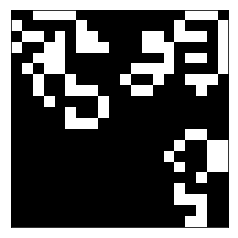

In [24]:
show_field(Y)

In [25]:
gs = MPGeneticSolver(verbosity=1, n_generations=500, population_size=400)

In [26]:
res = gs.solve(Y, 3)

NameError: name 'make_move' is not defined